## Inference for the Armond model via particle MCMC 

## Fitting models of metaphase kinetochore oscillations to synthetic data

The model used is the model from [Armond et al. (2015, PloS Comp. Biol.)](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1004607). This is an SDE dependent on hidden states. 
The key equation for this model is as follows, obtained from discretizing the SDE: 

\begin{align}
(X_{t+\Delta t}^1 - X_t^1)/\Delta t = -v_{\sigma_t^1} -\kappa \left( X_t^1 - X_t^2 -L\cos \theta_t  \right) - \alpha X_t^1 + N(0,s^2), \\
(X_{t+\Delta t}^2 - X_t^2)/\Delta t = +v_{\sigma_t^2} -\kappa \left( X_t^2 - X_t^1 +L\cos \theta_t  \right) - \alpha X_t^2 + N(0,s^2),
\end{align}
where $\sigma_1$ and $\sigma_2$ are hidden states taking values in the set $$(\sigma_1, \sigma_2) \in \{ (+,+),(+,-),(-,+),(-,-) \}$$
with switching rates $p_{coh}$ and $p_{icoh}$ between states based on whether $\sigma_1$ and $\sigma$ are the same (incoherent) or not (coherent). 

To fit this model, we use SMC2 which uses a particle filter both for the discrete hidden states and in parameter space nested together. This an alternative to using a traditional Metropolis-Hastings type kernel to explore parameter space with accept-reject decisions based on a particle filter as in particle marginal Metropolis Hastings (PMMH) methods. One of the motivations for SMC2 in this context is that it should require less tuning than the PMMH methods. These methods are implemented via [Libbi](http://libbi.org/), which can make use of the parallel computing architectures on modern machines. 


We can load the library and set things up as follows

In [1]:
using SMC, Random, Distributions, DataFrames
trueValues = [450, 0.008, 0.025, -0.035, 0.015, 0.9, 0.95, 0.775]
thetaDF = DataFrame(paramNames = ["tau","alpha","kappa","v_minus","v_plus","p_icoh","p_coh","L"],
                    trueValues = trueValues)
th = thetaSimple(trueValues[1], trueValues[2], trueValues[3], trueValues[4],
    trueValues[5], trueValues[6], trueValues[7], trueValues[8], 2.0)
(armondhmmSimple, transll, approxtrans, approxll) = armondModelSimple(th)
hmm = HMM(armondhmmSimple, transll)
x0 = [0, 1.0, 0, 0];
y0 = [0.9, 0];

We generate synthetic data from the model and plot to check that this looks as it should.
We can then use this synthetic data to infer known model parameters.

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/jonathanharrison/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


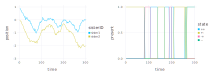

In [2]:
### generation from armond model
Random.seed!(123)
K=150
(states, observations) = generate(armondhmmSimple, x0, y0, K);

### preparation for plotting
using Gadfly, DataFrames
set_default_plot_size(21cm, 8cm)
dfObs = DataFrame(transpose(observations));
dfStates = DataFrame(transpose(states));
names!(dfObs, [Symbol("sister$i") for i in 1:2]) #change columns names, see https://stackoverflow.com/questions/21559683/how-do-you-change-multiple-column-names-in-a-julia-version-0-3-dataframe
names!(dfStates, [Symbol("++"), Symbol("+-"), Symbol("-+"), Symbol("--")])
dfT = DataFrame(time = th.dt*collect(1:K));
df = [dfT dfObs dfStates]
df = stack(df,[:sister1, :sister2], variable_name=Symbol("sisterID"),value_name=Symbol("position")) #reshape from wide to long
df = stack(df, 4:7, variable_name=Symbol("state"), value_name=Symbol("present"))
p1 = plot(df, x="time",y = "position", color="sisterID", Geom.line)
p2 = plot(df, x="time",y = "present", color="state", Geom.line)
hstack(p1,p2)

In [19]:
#prepare for parallel processing
using Distributed
addprocs(8)
module_dir = "/Users/jonathanharrison/.julia/dev/SMC.jl"
@everywhere push!(LOAD_PATH, $module_dir) #see https://discourse.julialang.org/t/loading-modules-on-remote-workers-in-julia-1-0-7/13312/3
@everywhere using Distributions, SMC, Random


In [21]:
prop = auxiliaryprop(armondhmmSimple, x0, approxtrans, approxll)
@everywhere function unpackPF(M)
(psf, ess, ev) = particlefilter(hmm, observations, M, prop)
return ev
end

#=M=16;
@time for i=1:8 
ev = unpackPF(M);
end
@time @distributed (+) for i=1:8 
    unpackPF(M);
end =#

In [22]:
using LinearAlgebra
# We create an array of matrices.
M = Matrix{Float64}[rand(1000, 1000) for i = 1:10];
@time pmap(svd, M); # Compute the svd for each of them.

  6.855624 seconds (3.33 M allocations: 380.132 MiB, 7.46% gc time)


In [24]:
@everywhere trueValues = [450, 0.008, 0.025, -0.035, 0.015, 0.9, 0.95, 0.775]
@everywhere th = thetaSimple(trueValues[1], trueValues[2], trueValues[3], trueValues[4],
    trueValues[5], trueValues[6], trueValues[7], trueValues[8], 2.0)
@everywhere (armondhmmSimple, transll, approxtrans, approxll) = armondModelSimple(th)
@everywhere y0 = [0.9, 0];
@everywhere x0 = [0, 1.0, 0, 0];
@everywhere K=150;
@everywhere (states, observations) = generate(armondhmmSimple, x0, y0, K);
@everywhere prop = auxiliaryprop(armondhmmSimple, x0, approxtrans, approxll)
@everywhere hmm = HMM(armondhmmSimple, transll)
@everywhere h(x) = prop.mean(1, [0, 0, 1, 0], [0.9, 0.1], [0.85,0.01], rand())
#@everywhere q(x) = hmm.transloglik(1, [0, 0, 1, 0], [0, 0, 1, 0]) +
                        hmm.obsloglik(1, [0.9, 0.1], [0.85, 0.01], [0, 0, 1, 0]) -
                        prop.loglik(1, [0, 0, 1, 0], [0.9, 0.1], [0.85, 0.01], [0, 0, 1, 0])
#@everywhere h(x) = particlefilter(hmm, observations, 16, prop,
#                                  resampling=systematicresampling, u=nothing)
@time f_pmap(h,1:10);
#@time map(h,1:8);

  0.057408 seconds (716 allocations: 36.813 KiB)


In [113]:
nBench = 10^4
@time for i=1:nBench
    h(i);
      end
@time f_pmap(h,1:nBench);
@time Threads.@threads for i in 1:nBench
    h(i);
end  
@time @distributed for i in 1:nBench
    h(i);
end
#notes: strategy suggested by darren wilkinson should work (run several particle filters with smaller number of particles and take an average)
#might be possible to parallelise properly using fine level control. Maybe sharedarrays and @distributed would work

  0.089887 seconds (1.12 M allocations: 66.211 MiB, 21.52% gc time)
  0.584883 seconds (599.76 k allocations: 19.602 MiB, 1.13% gc time)
  0.095788 seconds (1.11 M allocations: 66.827 MiB, 18.12% gc time)
  0.009205 seconds (7.99 k allocations: 421.198 KiB)


Task (queued) @0x000000011aae2ad0

In [25]:
const jobs = RemoteChannel(()->Channel{Int}(32));
const results = RemoteChannel(()->Channel{Tuple}(32));
@everywhere function do_work(jobs, results) # define work function everywhere
       while true
           job_id = take!(jobs)
           exec_time = rand()
           unpackPF(16);
           put!(results, (job_id, exec_time, myid()))
       end
   end

function make_jobs(n)
       for i in 1:n
           put!(jobs, i)
       end
   end;

n = 8;
@time for i=1:n
    unpackPF(16);
end

@async make_jobs(n); # feed the jobs channel with "n" jobs

for p in workers() # start tasks on the workers to process requests in parallel
       remote_do(do_work, p, jobs, results)
   end
@elapsed while n > 0 # print out results
       job_id, exec_time, where = take!(results)
       println("$job_id finished in $(round(exec_time; digits=2)) seconds on worker $where")
       global n = n - 1
   end

  0.577398 seconds (4.81 M allocations: 278.683 MiB, 27.66% gc time)
4 finished in 0.06 seconds on worker 6
2 finished in 0.99 seconds on worker 3
1 finished in 0.76 seconds on worker 2
8 finished in 0.12 seconds on worker 7
7 finished in 0.54 seconds on worker 4
6 finished in 0.73 seconds on worker 8
3 finished in 0.13 seconds on worker 5
5 finished in 0.42 seconds on worker 9


0.222439655

In [27]:
@time for i=1:10
    (psf, ess, ev) = parallelParticlefilter(hmm, observations, 16, prop,
                                  resampling=systematicresampling, u=nothing);
end

2


RemoteException: On worker 2:
UndefVarError: ##210#212 not defined
deserialize_datatype at /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/Serialization/src/Serialization.jl:1115
handle_deserialize at /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/Serialization/src/Serialization.jl:771
deserialize at /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/Serialization/src/Serialization.jl:731
handle_deserialize at /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/Serialization/src/Serialization.jl:778
deserialize_msg at /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/Serialization/src/Serialization.jl:731
#invokelatest#1 at ./essentials.jl:742 [inlined]
invokelatest at ./essentials.jl:741 [inlined]
message_handler_loop at /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/Distributed/src/process_messages.jl:160
process_tcp_streams at /Users/osx/buildbot/slave/package_osx64/build/usr/share/julia/stdlib/v1.1/Distributed/src/process_messages.jl:117
#105 at ./task.jl:259

In [ ]:
#@time for i=1:100
@time q = runFilter([0.9,0.95],nothing,observations; N=64,filterMethod="Aux")
#    end

  7.032275 seconds (5.48 M allocations: 277.941 MiB, 1.51% gc time)
  0.703083 seconds (190.45 k allocations: 9.471 MiB)
  1.319732 seconds (8.78 k allocations: 334.469 KiB)
  2.941272 seconds (8.82 k allocations: 332.172 KiB)
Optimum is N=64 with a variance of 1.740513844071635
  0.132236 seconds (8.74 k allocations: 331.234 KiB)
  0.150165 seconds (8.74 k allocations: 330.516 KiB)
  0.277043 seconds (8.77 k allocations: 331.109 KiB)
  0.560605 seconds (8.80 k allocations: 330.344 KiB)
  1.246865 seconds (8.76 k allocations: 332.656 KiB)
  2.804053 seconds (8.79 k allocations: 334.313 KiB)
  5.575127 seconds (8.95 k allocations: 335.656 KiB)
Optimum is N=512 with a variance of 1.864195177130834


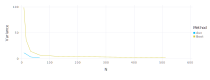

In [4]:
#Optimize the number of particles to use in the particle filter
using DataFrames
using Statistics: var
Random.seed!(123) #not sure this seeds properly on all processes
function getOptimumNumParticles(; NVec = 2 .^(3:10), th_star::Array = [0.9, 0.95],
                                nRepeats::Int=100, filter::String="Aux", u=nothing)
    llVar = zeros(length(NVec))
    i = 1
    @time llVar[i] =  var(pmap(x -> runFilter(th_star, u, observations; N=NVec[i], filterMethod=filter), 1:nRepeats))
    while llVar[i] > 3
        i+=1
        if i>length(NVec)
            println("Unable to find optimum N")
            break
        end
        @time llVar[i] =  var(pmap(x -> runFilter(th_star, u, observations; N=NVec[i], filterMethod=filter), 1:nRepeats))
    end
    println("Optimum is N=", NVec[i], " with a variance of ", llVar[i])
    return DataFrame(N=NVec[1:i], Variance=llVar[1:i], Method = repeat([filter],i))
end
filterMethods = ["Aux","Boot"]
out = map(x -> getOptimumNumParticles(th_star = thetaDF[:trueValues],
        filter=x), filterMethods)
Ndf = [out[1]; out[2]]
Gadfly.plot(Ndf, x="N",y="Variance",color="Method", Geom.line)

Now we can specify parameter proposal distributions and run multiple chains of the particle MCMC. Use pilot run to estimate the variance to use for proposal distribution. 

In [5]:
Random.seed!(125)
dimParams = 2
proposalWidthLU = [50 0 Inf;
                   0.01 0 Inf;
                   0.01 0 Inf;    
                   0.02 -Inf 0;     
                   0.02 0 Inf;           
                   0.05 0 1;
                   0.05 0 1;
                   0.05  0 Inf] #std, lower and upper for truncated normal proposal
paramProposal = [x -> TruncatedNormal(x,proposalWidthLU[i,1],proposalWidthLU[i,2],proposalWidthLU[i,3]) for i in 1:dimParams]
priors = [Gamma(1/0.5,1/0.001), #tau: shape vs rate paramterisation
    TruncatedNormal(0.01,sqrt(10000),0,Inf), #alpha
    TruncatedNormal(0.05,sqrt(10000),0,Inf), #kappa
    TruncatedNormal(-0.03,sqrt(10),-Inf,0), #v_minus
    TruncatedNormal(0.03, sqrt(10),0,Inf), #v_plus
    Beta(2,1), #p_icoh
    Beta(2.5,1), #p_coh
    TruncatedNormal(0.775,sqrt(0.0121),0,Inf) #L
]
initialisationFn = [TruncatedNormal(450,100,0,Inf), #tau: shape vs rate paramterisation
    TruncatedNormal(0.01,0.01,0,Inf), #alpha
    TruncatedNormal(0.025,0.01,0,Inf), #kappa
    TruncatedNormal(-0.03,0.02,-Inf,0), #v_minus
    TruncatedNormal(0.03,0.02,0,Inf), #v_plus
    TruncatedNormal(0.9,0.1,0,1), #p_icoh
    TruncatedNormal(0.95,0.1,0,1), #p_coh
    TruncatedNormal(0.775,0.1,0,Inf) #L
]
if dimParams==2
    #use simpler model with only p_coh and p_icoh
    proposalWidthLU = proposalWidthLU[6:7,:]
    priors = priors[6:7]
    initialisationFn = initialisationFn[6:7]
end
numIter = 20000
nChains = 6
N = 64;
numRandoms = K*(N+1);


In [6]:
#pilot run to estimate variance
using MCMCChains
numIterPilot = 1000
thin = 1
nThinned = Int(numIterPilot/thin)

@time (cPilot,actRatePilot) = correlated(observations, priors,
         paramProposal, dimParams, numRandoms, numIter=numIterPilot,
         printFreq=100, initialisationFn=initialisationFn, N=N);

#with better variance estimation
chn=Chains(reshape(cPilot[1:thin:end,:],nThinned,dimParams,1), start=1, thin=thin)
minESS = minimum(ess(chn)[:,:ess])
mu = sum(cPilot[1:thin:end,:],dims=1)/nThinned
varPilot = sum((cPilot[1:thin:end,:] .- repeat(mu,nThinned)).^2,dims=1)/minESS
println(varPilot)
scalingFactor = 2.56/dimParams #see Golightly et al 2017
#set optimized Proposal
paramProposalOptim = [x -> TruncatedNormal(x,sqrt(varPilot[i])*scalingFactor,proposalWidthLU[i,2],proposalWidthLU[i,3]) for i in 1:dimParams];

Iter: 100
acceptance rate is: 0.24
Iter: 200
acceptance rate is: 0.32
Iter: 300
acceptance rate is: 0.3233333333333333
Iter: 400
acceptance rate is: 0.2975
Iter: 500
acceptance rate is: 0.324
Iter: 600
acceptance rate is: 0.3233333333333333
Iter: 700
acceptance rate is: 0.30714285714285716
Iter: 800
acceptance rate is: 0.31625
Iter: 900
acceptance rate is: 0.3188888888888889
Iter: 1000
acceptance rate is: 0.321
212.855756 seconds (2.41 G allocations: 136.525 GiB, 19.88% gc time)
[0.202604 0.0399983]


┌ Info: Recompiling stale cache file /Users/jonathanharrison/.julia/compiled/v1.1/StatsPlots/SiylL.ji for StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1184


      From worker 9:	┌ Warning: `@nodeps` is deprecated. Simply use e.g. `Widgets.dropdown(x)` instead of `Widgets.@nodeps dropdown(x)`.
      From worker 9:	└ @ Widgets ~/.julia/packages/Widgets/AcUe0/src/utils.jl:63
      From worker 9:	┌ Warning: `@nodeps` is deprecated. Simply use e.g. `Widgets.dropdown(x)` instead of `Widgets.@nodeps dropdown(x)`.
      From worker 9:	└ @ Widgets ~/.julia/packages/Widgets/AcUe0/src/utils.jl:63
      From worker 9:	┌ Warning: `@nodeps` is deprecated. Simply use e.g. `Widgets.dropdown(x)` instead of `Widgets.@nodeps dropdown(x)`.
      From worker 9:	└ @ Widgets ~/.julia/packages/Widgets/AcUe0/src/utils.jl:63
      From worker 9:	┌ Warning: `@nodeps` is deprecated. Simply use e.g. `Widgets.dropdown(x)` instead of `Widgets.@nodeps dropdown(x)`.
      From worker 9:	└ @ Widgets ~/.julia/packages/Widgets/AcUe0/src/utils.jl:63
      From worker 9:	┌ Warning: `@nodeps` is deprecated. Simply use e.g. `Widgets.dropdown(x)` instead of `Widgets.@nodeps dropd

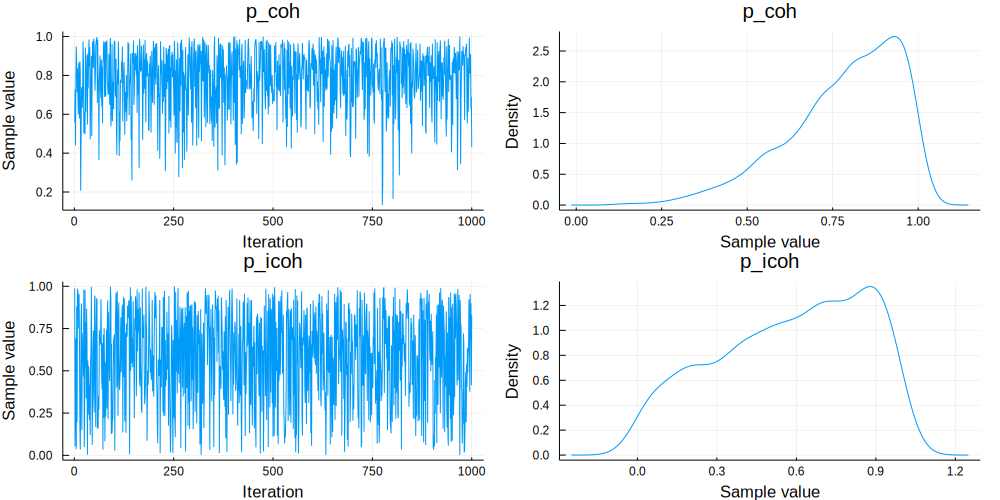

In [7]:
#use this to check proposal distribution 
using MCMCChains, StatsPlots
if dimParams == 8
    th_init = [450,0.01,0.025,-0.03,0.03,0.9,0.95,0.8]
    paramNames = ["tau","alpha","kappa","v_minus","v_plus","p_icoh","p_coh","L"]
elseif dimParams == 2
    th_init = [0.9,0.95]
    paramNames = ["p_icoh","p_coh"]
else
    error("wrong number of parameters specified")
end
priorSamples = zeros(numIterPilot,dimParams,1)
for i=1:dimParams 
    priorSamples[:,i,1] = rand(paramProposalOptim[i](th_init[i]),numIterPilot)
end
prChn = Chains(priorSamples,paramNames)
# visualize the MCMC simulation results
p1 = StatsPlots.plot(prChn, colordim = :parameter)
p2 = StatsPlots.plot(prChn)

In [8]:
@time out = pmap(x -> correlated(observations, priors,
         paramProposalOptim, dimParams, numRandoms,
         numIter=numIter, printFreq=1000, initialisationFn=initialisationFn,
         N=N, rho=0.99), 1:nChains);


      From worker 2:	Iter: 1000
      From worker 2:	acceptance rate is: 0.039
      From worker 7:	Iter: 1000
      From worker 7:	acceptance rate is: 0.061
      From worker 5:	Iter: 1000
      From worker 5:	acceptance rate is: 0.046
      From worker 6:	Iter: 1000
      From worker 6:	acceptance rate is: 0.051
      From worker 9:	Iter: 1000
      From worker 9:	acceptance rate is: 0.068
      From worker 8:	Iter: 1000
      From worker 8:	acceptance rate is: 0.067
      From worker 2:	Iter: 2000
      From worker 2:	acceptance rate is: 0.037
      From worker 7:	Iter: 2000
      From worker 7:	acceptance rate is: 0.0575
      From worker 5:	Iter: 2000
      From worker 5:	acceptance rate is: 0.044
      From worker 6:	Iter: 2000
      From worker 6:	acceptance rate is: 0.0675
      From worker 9:	Iter: 2000
      From worker 9:	acceptance rate is: 0.0445
      From worker 8:	Iter: 2000
      From worker 8:	acceptance rate is: 0.058
      From worker 2:	Iter: 3000
      From worker

In [9]:
#extracting from output of pmap is a bit messy; https://stackoverflow.com/questions/44234255/return-multiple-values-from-a-mapped-function
cTemp, actRate = map(x->getindex.(out, x), 1:2)
c =  zeros(numIter,dimParams,nChains)
for i=1:nChains
    c[:,:,i] = cTemp[i]
end

We can plot the chains and assess convergence. 


In [15]:
using MCMCChains, StatsPlots
theme(:ggplot2)
thetaDFCopy = (dimParams==8) ? thetaDF : (dimParams==2) ? thetaDF[6:7,:] : nothing 
thin = 1
chn=Chains(c[1:thin:end,:,:], thetaDFCopy[:paramNames], start=1, thin=thin);
Rhat = gelmandiag(chn)
println(Rhat)

# visualize the MCMC simulation results
p1 = StatsPlots.plot(chn, colordim = :parameter);
p2 = StatsPlots.plot(chn, width=3, layout = [8,2]);
th_true = 0
for i=1:dimParams
    for j=1:dimParams
        if string(Rhat[:parameters][i]) == thetaDFCopy[:paramNames][j]
            th_true = thetaDFCopy[:trueValues][j]
            break
        end
    end
    StatsPlots.plot!(p2[i,1],1:numIter, repeat([th_true],numIter),color="black",linestyle=:dash)
#    StatsPlots.plot!(p2[i,2],repeat([th_true],100), range(0,stop=10/th_true,length=100),color="black")
end
p2

Gelman, Rubin, and Brooks Diagnostic

│ Row │ parameters │ PSRF    │ 97.5%   │
│     │ Symbol     │ Float64 │ Float64 │
├─────┼────────────┼─────────┼─────────┤
│ 1   │ p_coh      │ 1.01225 │ 1.03009 │
│ 2   │ p_icoh     │ 1.01549 │ 1.03819 │


In [16]:
show(chn)

Object of type Chains, with data of type 20000×2×6 Array{Float64,3}

Iterations        = 1:20000
Thinning interval = 1
Chains            = 1, 2, 3, 4, 5, 6
Samples per chain = 20000
parameters        = p_icoh, p_coh

2-element Array{ChainDataFrame,1}

Summary Statistics

│ Row │ parameters │ mean     │ std       │ naive_se    │ mcse        │ ess     │ r_hat   │
│     │ Symbol     │ Float64  │ Float64   │ Float64     │ Float64     │ Any     │ Any     │
├─────┼────────────┼──────────┼───────────┼─────────────┼─────────────┼─────────┼─────────┤
│ 1   │ p_coh      │ 0.921239 │ 0.0428843 │ 0.000123796 │ 0.000844307 │ 1016.48 │ 1.0181  │
│ 2   │ p_icoh     │ 0.815305 │ 0.0930974 │ 0.000268749 │ 0.00186628  │ 964.546 │ 1.02371 │

Quantiles

│ Row │ parameters │ 2.5%     │ 25.0%    │ 50.0%    │ 75.0%    │ 97.5%    │
│     │ Symbol     │ Float64  │ Float64  │ Float64  │ Float64  │ Float64  │
├─────┼────────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ 1   │ p_coh      │ 0.82540

In [12]:
#=
using SMC, Gadfly
Random.seed!(123)
K=150
(states, observations) = generate(armondhmmSimple, x0, y0, K);
nGrid = 11
p_nochange = range(0.5, stop=1.0, length=nGrid)
N=64
function gridEvalFilter(gr, nGrid, N)
    ll = zeros(nGrid,nGrid)
    for (i,th1) in enumerate(gr)
        for (j,th2) in enumerate(gr)
            th_star = [th1, th2]
            ll[i,j] = runFilter(th_star, rand(2), observations; N=N)
        end
    end
    return ll
end
ll = gridEvalFilter(p_nochange, nGrid, N);
=#


In [13]:
#p2 = plot(x = collect(p_nochange),y = ll[:,5], Geom.line)

In [14]:
#p1 = plot(x = collect(p_nochange), y = collect(p_nochange), z=ll, Geom.contour)